# Life expectancy regression tasks using Support vector machines, Random Forests and Neural networks

We perform regression on the WHO data to predict life expectancy, using SVM, random forests and NN. We first process the data, removing non-numerical features, features which are heavily skewed and then normalise the train and test sets independently to avoid leakage. We then set the models and check the associated metrics to find that the predictions of life expectancy are solid with $R^2$ score rating of $+0.8$.

The data is available at https://www.kaggle.com/datasets/kumarajarshi/life-expectancy-who/data, and some of the setup and preprocessing follows https://www.kaggle.com/code/vstacknocopyright/modeling-life-expectancy-using-regression-algo-s.

## Data pre-processing 

In [1]:
import pandas as pd 
import numpy as np
import sklearn 
from sklearn.svm import SVR
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler

In [2]:
df=pd.read_csv("life_ex_data.csv")
print(df.shape)
df.head()

(2938, 22)


,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


The dataset contains not a number values, and so we import the SimpleImputer to replace these with the means of the columns (setting the `strategy` option). Note that while this is effectively introducing new data, it avoids losing substantial data which would occur if we dropped full rows or columns.

In [3]:
#Fetch the columns which are having null values
df.columns[df.isnull().any()]

Index(['Life expectancy ', 'Adult Mortality', 'Alcohol', 'Hepatitis B',
       ' BMI ', 'Polio', 'Total expenditure', 'Diphtheria ', 'GDP',
       'Population', ' thinness  1-19 years', ' thinness 5-9 years',
       'Income composition of resources', 'Schooling'],
      dtype='object')

In [4]:
from sklearn.impute import SimpleImputer

imp=SimpleImputer(missing_values=np.NaN,strategy='mean')
list=['Adult Mortality', 'Alcohol', 'Hepatitis B', ' BMI ', 'Polio',
       'Total expenditure', 'Diphtheria ', 'GDP', 'Population',
       ' thinness  1-19 years', ' thinness 5-9 years',
       'Income composition of resources', 'Schooling', 'Life expectancy ']
for i in list:
    df[i]=imp.fit_transform(df[i].values.reshape(-1,1))

#check again if any null values are present after performing simple imputer operation
print(df.isna().sum())

Country                            0
Year                               0
Status                             0
Life expectancy                    0
Adult Mortality                    0
infant deaths                      0
Alcohol                            0
percentage expenditure             0
Hepatitis B                        0
Measles                            0
 BMI                               0
under-five deaths                  0
Polio                              0
Total expenditure                  0
Diphtheria                         0
 HIV/AIDS                          0
GDP                                0
Population                         0
 thinness  1-19 years              0
 thinness 5-9 years                0
Income composition of resources    0
Schooling                          0
dtype: int64


Skew analysis should also be done. Skew analysis shows large amounts of data acculumate in small area of the feature space, so remove these columns, as well as non-numerical. 

Split data before any normalisation. Note if we did not, when we normalise over columns, we essentially use information from ALL data.
This can be a form of leakage, as some of the training data will be rescaled using "some of the test data information" (both sets are involved in the normalisation, so normalised training data would depend on the test data, at least in an indirect way).

In [5]:
print(df.shape)
df_2 = df.drop(columns=["Country", "Year", "Status"," HIV/AIDS"]) # Dropping columns not used in training
x_df=df_2.drop(columns=["Life expectancy "]) # Dropping columns not used in training
y_df=df_2["Life expectancy "]
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(x_df,y_df,test_size=0.3)

(2938, 22)


Note here we only standardise/transform the input data so it is easier for the network to process. The output data, y_train and y_test are the target
variables and features we are looking to predict. Standardizing them would mean that the output is not directly interpretable. We look at life 
expectancy and there is no meaning as a value between 0 and 1, we want it in years.

In [6]:
min_max = MinMaxScaler()
norm_X_train = pd.DataFrame(min_max.fit_transform(X_train), columns = X_train.columns)
norm_X_test = pd.DataFrame(min_max.fit_transform(X_test), columns = X_test.columns)
print(norm_X_train.shape)
print(norm_X_test.shape)

(2056, 17)
(882, 17)


Having removed the NaN entries, removed the columns that suffered from large skew (`"Country", "Year", "Status"," HIV/AIDS"]`), and normalised using MinMaxScaler separately on the train and testing input data, we can now plug this into the different models.

## SVM model regression

In [7]:
#Applying SVR and checking model accuracy
#svr=SVR()

svr=SVR(kernel='rbf')
svp=SVR(kernel='poly')
svl=SVR(kernel='linear')

model=[svr,svp,svl]

for i in model:
    i.fit(norm_X_train,y_train)
    print(i,i.score(norm_X_train,y_train))
    preds=i.predict(norm_X_test)
    print('Mean Squared error: ',mean_squared_error(y_test,preds))
    print('Mean Absolute error: ',mean_absolute_error(y_test,preds))
    print('Root Mean Squared error: ',np.sqrt(mean_squared_error(y_test,preds)))
    print('\n')

SVR() 0.8151438216592031
Mean Squared error:  17.00545571419619
Mean Absolute error:  2.7907093246454067
Root Mean Squared error:  4.1237671750713805


SVR(kernel='poly') 0.8141989019465958
Mean Squared error:  16.272502464017244
Mean Absolute error:  2.7890358136668483
Root Mean Squared error:  4.033918995718338


SVR(kernel='linear') 0.7463293511003533
Mean Squared error:  23.652394672383632
Mean Absolute error:  3.2782537449344438
Root Mean Squared error:  4.863372767163097




In [9]:
#Manual calculation of R^2. A bit different to the in-built method result
sv_test=svl
sv_test.fit(norm_X_train,y_train)
print(sv_test.score(norm_X_train,y_train))
preds_test=sv_test.predict(norm_X_test)

pred_mse= mean_squared_error(y_test,preds_test)
y_test_mse= mean_squared_error(y_test,np.ones_like(y_test)*np.mean(y_test))
print((1- (pred_mse/y_test_mse)))

0.7463293511003533
0.7251959339045964


Manually setting the degree of the polynomial and some of the epsilon window parameters in regression

In [10]:
svr_poly = SVR(kernel="rbf",degree=4,C=100,epsilon=0.01)
model1=svr_poly.fit(norm_X_train, y_train)
pred = model1.predict(norm_X_test)

Making some plots for life expectancy against different variables to see how well the model predicts

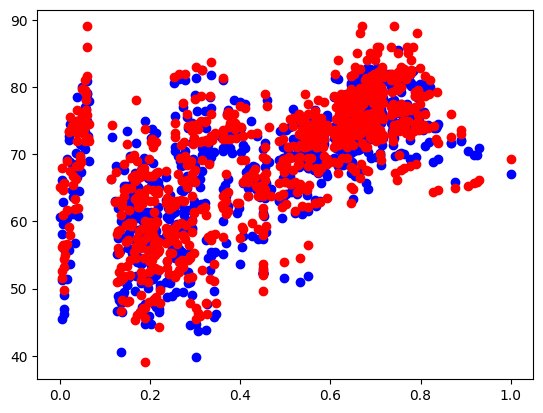

In [11]:
feats = ["Schooling", " BMI ", "Measles "]
choice=1
#plt.ylim((70,80))
#plt.xlim((0,100))
plt.scatter(np.array(norm_X_test[feats[choice]]),pred,c="b")
plt.scatter(np.array(norm_X_test[feats[choice]]),y_test,c="r")
plt.show()

In [12]:
len(svr_poly.support_vectors_)

2044

Projecting this up to a higher dimension, by studying BMI, Schooling and life expectancy helps get some more intuition about performance. Of course, we are still missing a huge number of features that would constitute other dimensions. This is important and we should not be misled by the lower dimensional image. The metric scores are what is most important in classifying the success.

The common metrics, as calculated above, are scaler quantities which allow us to compare the success of different models. Note `score` method calculates $R^2$, also known as the coefficient of determination. THe closer it is to 1, the better, and conversely for 0.

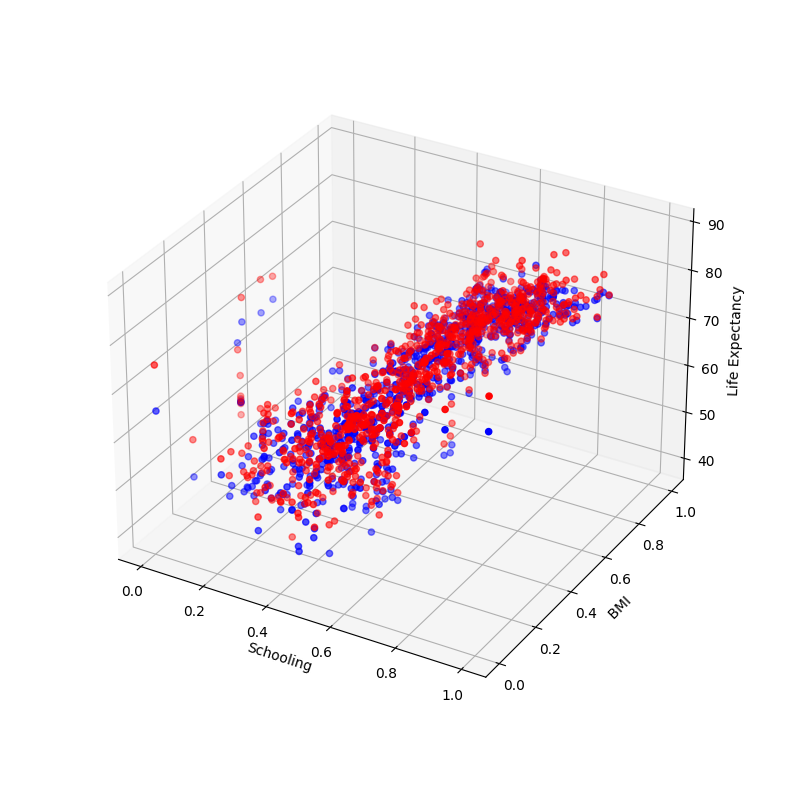

In [14]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')

ax.scatter(norm_X_test[feats[0]], norm_X_test[feats[1]],pred,c="b")
ax.scatter(norm_X_test[feats[0]], norm_X_test[feats[1]],y_test, c="r")
ax.set_xlabel(feats[0])
ax.set_ylabel(feats[1])
ax.set_zlabel("Life Expectancy")

ax.set_box_aspect(None, zoom=0.85)
plt.show()

## Random forest model regression

In [15]:
#Apply Random Forest Regressor and check score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.metrics import r2_score

rf=RandomForestRegressor(n_estimators=100,random_state=42)
rf.fit(norm_X_train,y_train)
rfpred=rf.predict(norm_X_test)
print('Random Forest score:',rf.score(norm_X_train,y_train))
print('Mean Squared Error: ',mean_squared_error(y_test,rfpred))
print('Mean Absolute Error: ',mean_absolute_error(y_test,rfpred))
print('R2 Score: ',r2_score(y_test,rfpred))

Random Forest score: 0.9939989559441991
Mean Squared Error:  6.065664264042692
Mean Absolute Error:  1.6340400116786247
R2 Score:  0.9295264083651226


In [16]:
rf.fit(norm_X_train,y_train)
print(rf.score(norm_X_train,y_train))

0.9939989559441991


In [17]:
rf_preds_test = rf.predict(norm_X_test)

#manual 1
rf_pred_mse= mean_squared_error(y_test,rf_preds_test)
y_test_ase= mean_squared_error(y_test,np.ones_like(y_test)*np.mean(y_test))
print(1- (rf_pred_mse/y_test_mse))

#manual 2
numer = ((y_test - rf_preds_test)** 2).sum()
denom =((y_test - y_test.mean()) ** 2).sum()
print(1- (numer/denom))

#Clearly the .score method deviates slighlty from the standard R^2 score 

0.9295264083651226
0.9295264083651226


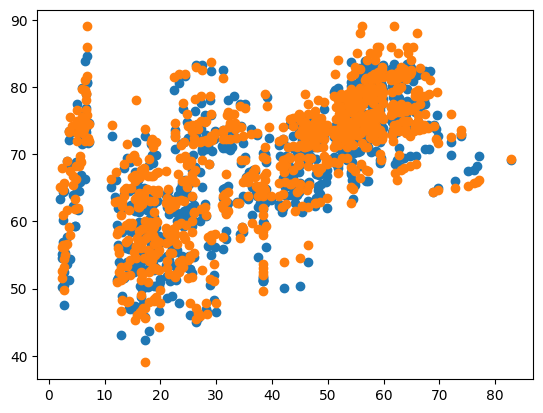

In [18]:
feats = ["Schooling", " BMI ", "Measles "]
choice=1

plt.scatter(X_test[" BMI "],rfpred)
plt.scatter(X_test[" BMI "],y_test)
plt.show()

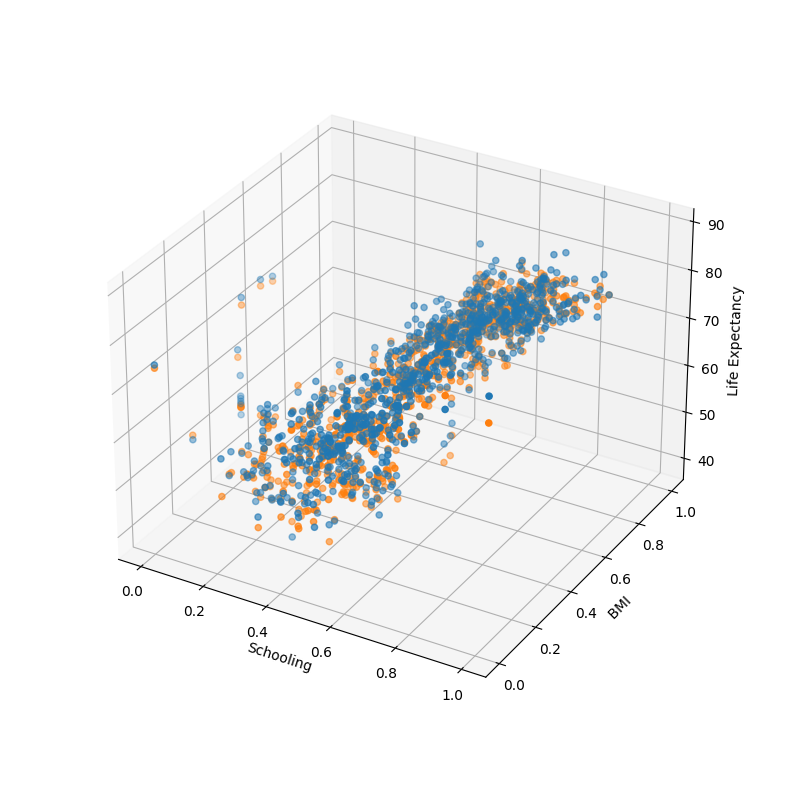

In [19]:
fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(projection='3d')

ax.scatter(norm_X_test[feats[0]], norm_X_test[feats[1]],y_test)
ax.scatter(norm_X_test[feats[0]], norm_X_test[feats[1]],rfpred)
ax.set_xlabel(feats[0])
ax.set_ylabel(feats[1])
ax.set_zlabel("Life Expectancy")

ax.set_box_aspect(None, zoom=0.85)
plt.show()

In both the random forest and SVM cases, clearly the models are able to make strong predicitions on people's life expectancy based on multiple features. As an aside, there are clear trends when we observe the (Schooling, BMI, Life expectancy) plots. Life expectancy naturally increases as BMI and Schooling increase. Again, this is a trend and correlation: there are more features that come into play.

Just as some further exploration, there is an outlier that has very large life expectancy but low schooling and BMI. We can identify what sample/row this is by inserting some conditions into the dataframe. See below.

In [20]:
X_test

,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
2236,9.0,8,0.09,196.380831,98.000000,294,65.6,9,98.0,3.86,98.0,2533.946200,1.275338e+07,7.5,7.4,0.818,14.5
806,168.0,55,0.22,0.000000,96.000000,26,57.8,64,96.0,5.40,96.0,7483.158469,1.275338e+07,2.9,2.9,0.671,12.4
534,37.0,46,0.47,4.982900,24.000000,165,16.7,80,32.0,3.31,24.0,84.455939,1.152786e+06,9.6,9.5,0.343,6.3
1337,119.0,4,0.61,535.278640,97.000000,2,6.1,4,98.0,8.78,97.0,3385.696650,6.489822e+06,3.8,3.8,0.739,13.6
516,443.0,16,1.66,58.529475,47.000000,679,2.7,24,47.0,3.73,47.0,494.336779,4.476153e+06,8.8,8.8,0.361,6.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2851,161.0,0,1.00,43.197808,59.000000,0,45.7,0,67.0,3.96,68.0,247.978230,2.146340e+05,1.6,1.5,0.572,10.6
1134,3.0,18,6.64,44.256871,80.940461,0,36.5,25,56.0,5.32,53.0,329.782946,8.976552e+06,4.5,4.6,0.447,8.1
1124,253.0,14,5.68,4.989712,68.000000,0,47.7,19,67.0,8.10,68.0,81.265673,1.431776e+06,3.9,3.9,0.483,9.1
1880,232.0,49,0.01,29.755180,71.000000,272,18.1,90,71.0,6.11,71.0,391.515524,1.773163e+07,1.3,1.1,0.331,5.1


In [21]:
X_test[(X_test["Schooling"]<4) & (X_test[" BMI "] < 10) ]

,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
76,151.0,0,7.16,1158.065259,99.0,0,4.1,0,99.0,4.53,99.0,9739.82556,1.275338e+07,3.5,3.5,0.0,0.0


In [22]:
y_test[(X_test["Schooling"]<4) & (X_test[" BMI "] < 10) ]

76    74.2
Name: Life expectancy , dtype: float64

Using the index, we pass this into the full dataframe to see that this row corresponds to a person from Antigua and Barbuda.

In [44]:
df.iloc[75]

Country                            Antigua and Barbuda
Year                                              2004
Status                                      Developing
Life expectancy                                   74.4
Adult Mortality                                  149.0
infant deaths                                        0
Alcohol                                           7.28
percentage expenditure                       22.862952
Hepatitis B                                       97.0
Measles                                              0
 BMI                                               4.8
under-five deaths                                    0
Polio                                             97.0
Total expenditure                                 4.21
Diphtheria                                        97.0
 HIV/AIDS                                          0.1
GDP                                          1352.8374
Population                             12753375.120052
 thinness 

## Neural network regressor

Another solution to this regression problem is to implement a neural network. A very simple one is given below with an input, 2 hidden and an output layer. Relu activation functions are used and the hidden layers have nodes1 and nodes2 lots of nodes. The final output layer is just a linear function and upon supplying with the normalised input, the output loss after 500 epochs is aroung 8.5, which is slightly better than SVM and slightly worse than Random Forests. Either way further tuning, like a learning rate scheduler/more layers/batching could decrease this futher.

In [23]:
print((X_train.shape[1],)) # Means we have n_feats=17 features as input, hence we should start the network off with an input layer of n_feats nodes
print((y_train.shape,))

(17,)
((2056,),)


We have a train and a test set, but a validation set is useful to see when we start overfitting by checking the training vs validation loss metrics. So we use train_test_split again to do this. Note: we split norm_X_train our normalised input data.

In [24]:
X_train_nn, X_val_nn, y_train_nn, y_val_nn = sklearn.model_selection.train_test_split(norm_X_train,y_train,test_size=0.2)
print(len(X_train_nn),len(X_val_nn),len(y_train_nn),len(y_val_nn))

1644 412 1644 412


In [25]:
import tensorflow as tf
nodes1 = 128 # first layer nodes
nodes2 = 256 # second layer nodes
lr=0.00015 # learning rate

model = tf.keras.Sequential()
model.add(tf.keras.Input(X_train.shape[1],)) #Input is the 17 remaining features
model.add(tf.keras.layers.Dense(nodes1,activation="relu"))
model.add(tf.keras.layers.Dense(nodes2,activation="relu"))
model.add(tf.keras.layers.Dense(1)) # Output is going to be the single "life expectancy" feature

opt = tf.keras.optimizers.Adam(learning_rate=lr)
loss = tf.keras.losses.MeanSquaredError()

model.compile(loss=loss, optimizer=opt, metrics=[tf.keras.losses.MeanSquaredError()])

In [26]:
history = model.fit(X_train_nn,y_train_nn,epochs=500, validation_data=(X_val_nn, y_val_nn))

Epoch 1/500
52/52 [==============================] - 1s 9ms/step - loss: 4772.4131 - mean_squared_error: 4774.8896 - val_loss: 4651.3779 - val_mean_squared_error: 4651.7051
Epoch 2/500
52/52 [==============================] - 0s 4ms/step - loss: 4499.1631 - mean_squared_error: 4496.8896 - val_loss: 4264.0835 - val_mean_squared_error: 4264.3809
Epoch 3/500
52/52 [==============================] - 0s 3ms/step - loss: 3943.3169 - mean_squared_error: 3933.8291 - val_loss: 3491.2800 - val_mean_squared_error: 3491.4917
Epoch 4/500
52/52 [==============================] - 0s 3ms/step - loss: 2956.2078 - mean_squared_error: 2953.6189 - val_loss: 2290.0344 - val_mean_squared_error: 2290.1157
Epoch 5/500
52/52 [==============================] - 0s 3ms/step - loss: 1683.5446 - mean_squared_error: 1673.4344 - val_loss: 1025.7704 - val_mean_squared_error: 1025.7832
Epoch 6/500
52/52 [==============================] - 0s 3ms/step - loss: 628.6567 - mean_squared_error: 624.3695 - val_loss: 273.7565 -

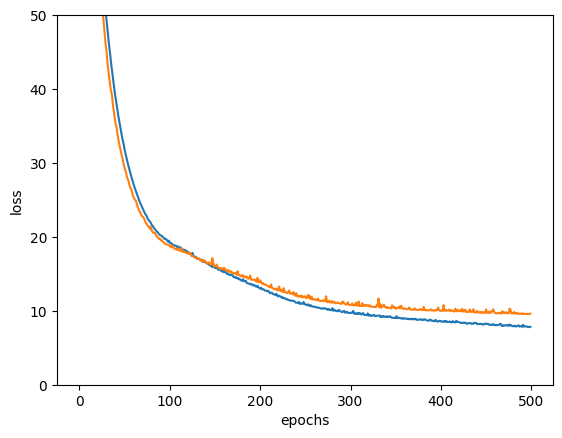

In [28]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.xlabel("epochs")
plt.ylabel("loss")
plt.ylim(0,50)
plt.show()

In [29]:
nn_preds=model.predict(norm_X_test)
print(len(nn_preds))
print(len(np.array([y_test])[0]))
print(nn_preds[0:10]) #Checking output
print(np.array([y_test])[0][0:10])

28/28 [==============================] - 0s 2ms/step
882
882
[[75.32284 ]
 [69.3152  ]
 [55.311905]
 [75.57616 ]
 [46.604706]
 [61.61354 ]
 [69.996414]
 [70.36331 ]
 [78.89051 ]
 [47.777832]]
[74.1 74.  57.  73.1 49.8 63.3 73.3 73.3 78.8 44.3]


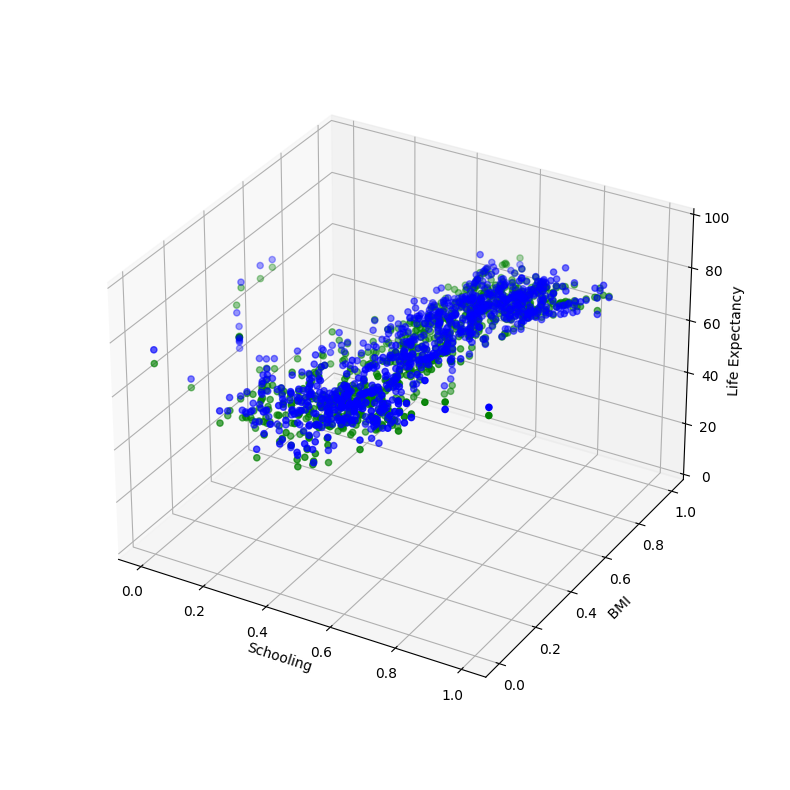

In [30]:
feats = ["Schooling", " BMI ", "Measles "]

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')

ax.scatter(norm_X_test[feats[0]], norm_X_test[feats[1]],nn_preds,c="g")
ax.scatter(norm_X_test[feats[0]], norm_X_test[feats[1]],y_test, c="b")
# ax.set_xlim3d(0,1)
# ax.set_ylim3d(0,1)
ax.set_zlim(0,100)
ax.set_xlabel(feats[0])
ax.set_ylabel(feats[1])
ax.set_zlabel("Life Expectancy")
ax.set_box_aspect(None, zoom=0.85)
plt.show()

Future investigations might include taking a closer look at those features that are clearly correlated Life expectancy and dropping other features from the training.